Este notebook tem como propósito testar o impacto da **redução de dimensionalidade** de **series temporais** univariadas na acurácia de diferentes classificadores. Para isso será testado a implementação de diferentes abordagens, como variações do algorítimo **PAA** (Piecewise Aggregate Approximation) utilizando estratégias de **pooling**, e também através de técnicas basedas em **Autoencoders**.

In [4]:
# Importa alguns pacotes úteis
import pandas as pd
import numpy as np
import time

Iniciamos explorando a utilização e manipulação de datasets de series temporais de benchmarking da biblioteca **aeon**. Exemplificando como carregar os datasets e como eles são armazenados.

In [5]:
# Importa uma lista de nomes de datasets de series temporais univariadas comumente utilizados em testes de benchamarking
from aeon.datasets.tsc_datasets import univariate as datasets

print(f"Lista com o nome dos {len(datasets)} datasets de benchmarking: \n{datasets}")

Lista com o nome dos 128 datasets de benchmarking: 
['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate'

In [6]:
# Para obter os dados de um dataset, precisamos carrega-lo em memória utilizando a função load_classification dísponível na biblioteca aeon
from aeon.datasets import load_classification

# Neste exemplo, utilizaremos o dataset "HouseTwenty" (disponível na lista de datasets carregada anteriormente)
dataset_name = 'HouseTwenty'

X_train, y_train = load_classification(dataset_name, split="train")
X_test, y_test = load_classification(dataset_name, split="test")

# Cada conjunto de dados carregado é composto por uma matriz 3D contendo: (n_intâncias, n_features, n_pontos) e um vetor 1D para as classes (labels)
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print()
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (40, 1, 2000)
y_train: (40,)

X_test: (119, 1, 2000)
y_test: (119,)


**Nota:** Podemos obter o tamanho (dimensionalidade) de uma série temporal selecionando o terceiro valor (`idx = 2`) dos dados carregados. No exemplo acima, o dataset **"HouseTwenty"** possui 159 séries (40 de treino + 119 de teste) de **2000 pontos (dimensões)**.

Como o escopo deste notebook só considera séries univariadas, o segundo valor (`idx = 1`) dos dados será sempre **1**, pois são séries de somente uma classe/feature.

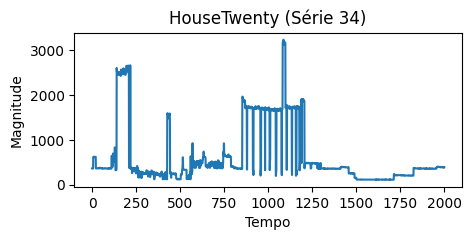

In [8]:
# Podemos plotar uma série temporal para visualização usando o matplotlib
import matplotlib.pyplot as plt

# Neste exemplo, plotamos uma instância qualquer (índice 34) da série do conjunto de treino que carregamos anteriormente do dataset "HouseTwenty"
idx = 34
serie = X_train[idx, 0, :] # Seleciona a série temporal da instância 34, feature 0 (única feature, pois é univariada)

plt.figure(figsize=(5,2))
plt.plot(serie) # Aqui selecionamos a série temporal da instância 34, feature 0 (única feature, pois é univariada) e todos os pontos (:)
plt.title(f"{dataset_name} (Série {idx})")
plt.xlabel("Tempo")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
# Para testar a redução de dimensionalidade das series destes datasets, é preciso selecionar series que possuam alta dimensionalidade (>=1000 pontos)
# Para isso, definimos uma lista para armazenar os nomes dos datasets que atendem a este critério

# A fim de verificar a dimensionalidade de cada dataset, iteramos sobre a lista de nomes de datasets originais (pode demorar alguns minutos).
high_dim_datasets = []
for d in datasets:
  X, y = load_classification(d, split='train')
  
  # Podem existir datasets que são implementados com diferentes formatos, sem ser Arrays do Numpy ou DataFrames, então usamos um bloco try-except para evitar erros ao tentar acessar o '.shape'
  try:
    if X.shape[2] >= 1000:
      print(f"{d}: {X.shape[2]}")
      high_dim_datasets.append(d)
  except AttributeError:
    pass

print(f"\n\nLista com o nome dos {len(high_dim_datasets)} datasets de benchmarking com séries univariadas e alta dimensionalidade (>=1000 pontos): \n{high_dim_datasets}")

ACSF1: 1460
CinCECGTorso: 1639
EOGHorizontalSignal: 1250
EOGVerticalSignal: 1250
EthanolLevel: 1751
HandOutlines: 2709
Haptics: 1092
HouseTwenty: 2000
InlineSkate: 1882
Mallat: 1024
MixedShapesRegularTrain: 1024
MixedShapesSmallTrain: 1024
Phoneme: 1024
PigAirwayPressure: 2000
PigArtPressure: 2000
PigCVP: 2000
Rock: 2844
SemgHandGenderCh2: 1500
SemgHandMovementCh2: 1500
SemgHandSubjectCh2: 1500
StarLightCurves: 1024
Lista com o nome dos 21 datasets de benchmarking com séries univariadas e alta dimensionalidade (>=1000 pontos): 
['ACSF1', 'CinCECGTorso', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'HandOutlines', 'Haptics', 'HouseTwenty', 'InlineSkate', 'Mallat', 'MixedShapesRegularTrain', 'MixedShapesSmallTrain', 'Phoneme', 'PigAirwayPressure', 'PigArtPressure', 'PigCVP', 'Rock', 'SemgHandGenderCh2', 'SemgHandMovementCh2', 'SemgHandSubjectCh2', 'StarLightCurves']


In [68]:
# Para treinar e testar classificadores, podemos utilizar a implementação de diferentes modelos disponíveis na biblioteca aeon
from aeon.classification.convolution_based import RocketClassifier
from aeon.classification.feature_based import Catch22Classifier
# Tambem podemos medir a acurácia (taxa de acerto) dos classificadores utilizando a biblioteca sklearn
from sklearn.metrics import accuracy_score

# Neste exemplo iremos treinar um classificar Rocket e medir sua acurácia no dataset "HouseTwenty" que carregamos anteriormente
# Tambem mediremos o tempo gasto para treinar o classificador utilizando o pacote 'time' importado no início deste notebook
start = time.time()
clf = RocketClassifier(n_kernels=10000, random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
end = time.time()

# Calcula o tempo gasto (em segundos) para treinar e testar o classificador (arredondado para 2 casas decimais)
elapsed = np.round(end - start, 2)

# Mede a acurácia das predições utilizando a função accuracy_score da biblioteca sklearn
acc = np.round(accuracy_score(y_test, predictions), 4)

print(f"-> Classificador Rocket\n\tDataset: HouseTwenty\n\tAcurácia: {acc}\n\tTempo gasto: {elapsed} segundos")


-> Classificador Rocket
	Dataset: HouseTwenty
	Acurácia: 0.9664
	Tempo gasto: 23.44 segundos


Na sequência iremos implementar a adaptaçao do algoritimo do **PAA** adaptado para receber o método a ser usado na agregação dos dados. Para facilitar futuras iterações e adaptações começaremos definindo os métodos de agregação que iremos trabalhar.

In [86]:
# Definimos uma lista de funções de agregação que serão aboradadas para a redução de dimensionalidade das séries temporais
aggregations = {
    'average': np.mean,
    'median': np.median,
    'max': np.max,
    'min': np.min,
    'sum': np.sum,
    'variance': np.var,
    'std': np.std,
    'iqr': lambda x: np.subtract(*np.percentile(x, [75, 25])),
    'first': lambda x: x[0],
    'central': lambda x: x[len(x)//2],
    'last': lambda x: x[-1],
    'max-min': lambda x: np.max(x) - np.min(x),
    'avg-max': lambda x: np.abs((np.mean(x) - np.max(x))),
    'avg-min': lambda x: np.abs((np.mean(x) - np.min(x))),
    'random': lambda x: np.random.choice(x)
}

In [78]:
# Aqui implemetamos a adaptação do algorítmo PAA para receber o método de agregação como argumento.
# Além do argumento 'agg' que define a função de agregação, o PAA recebe como argumentos a série temporal 's' que será reduzida e o novo tamanho 'w' desejado.
def PAA(s, w, agg='average'):
    if agg not in aggregations:
        raise ValueError(f"Função de agregação '{agg}' é inválida ou não suportada.")

    n = len(s)
    s = np.array(s)

    # Aqui criamos n valores uniformemente espaçados entre 0 e w (exclusivo).
    # Por exemplo: n=6 e w=2 será [0,0,0,1,1,1]
    idx = np.floor(np.linspace(0, w, n, endpoint=False)).astype(int)

    # Aqui iteramos sobre o tamanho desejado 'w' e aplicamos uma máscara para selecionar os pontos da série que pertencem a cada segmento.
    # Por exemplo: n=6 e w=2, o idx resultante será: 
    #              [True, True, True, False, False, False] para w = 0
    #              Assim podemos selecionar os pontos da série que pertencem a cada segmento.
    res = [aggregations[agg](s[idx == i]) for i in range(w)]

    return np.array(res)

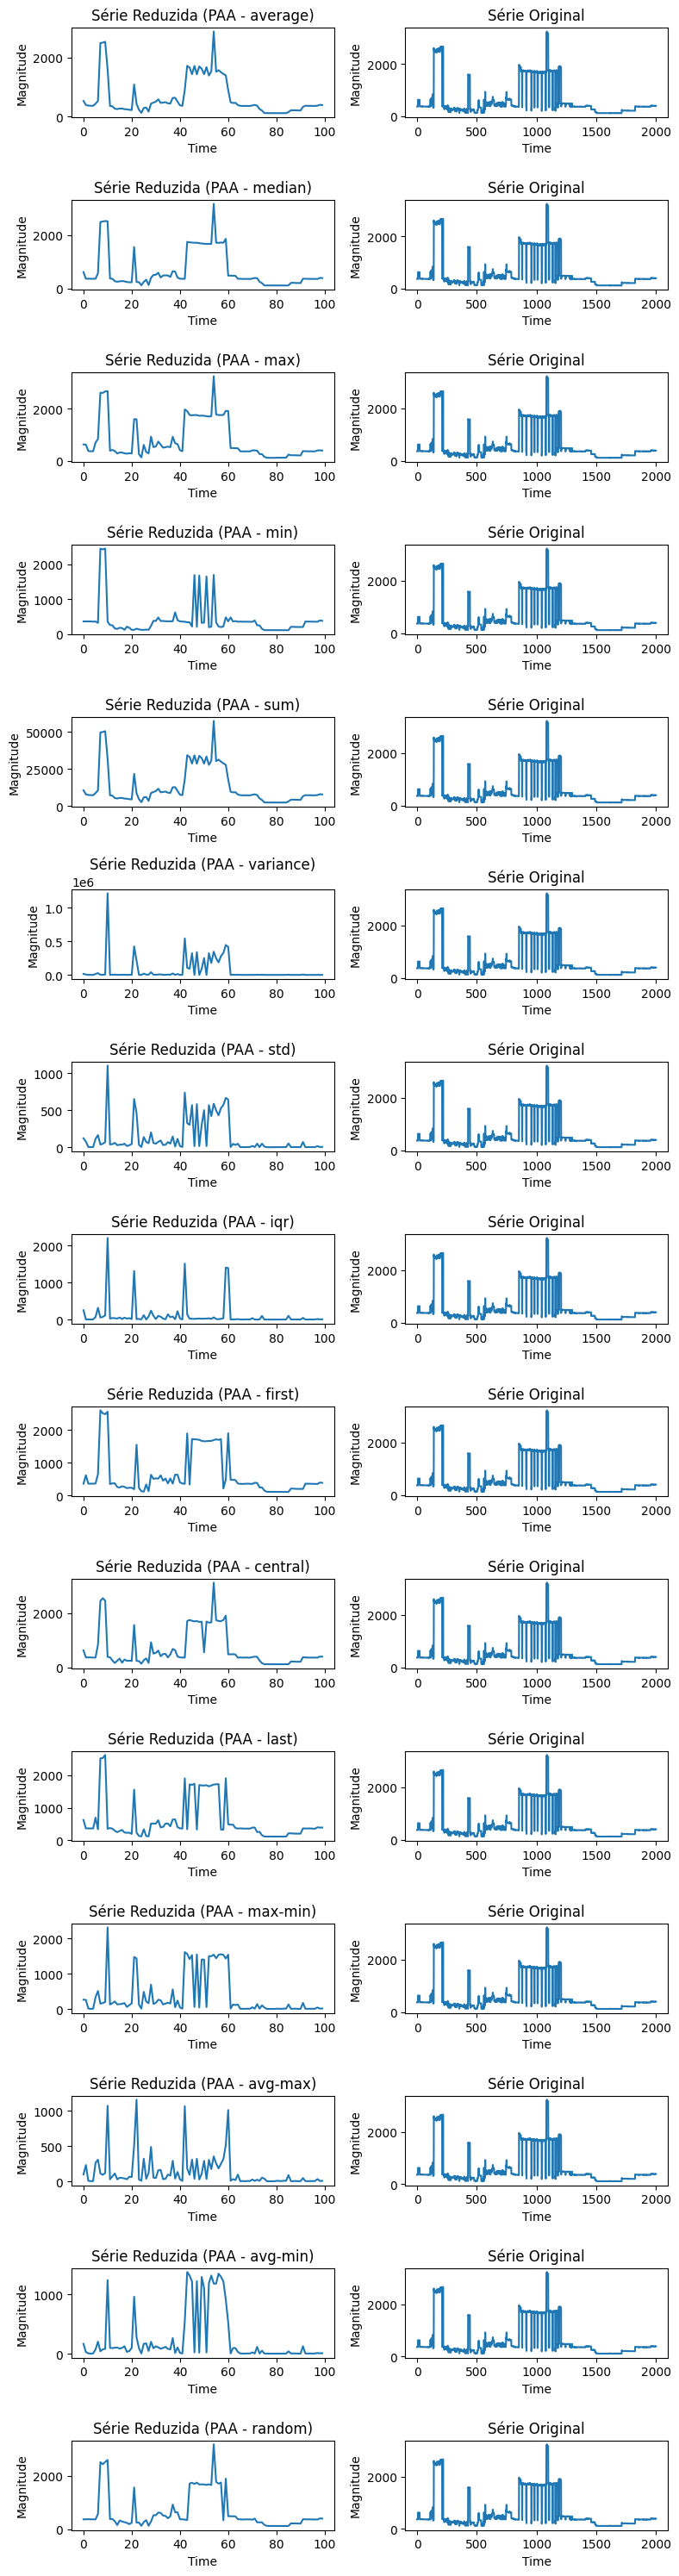

In [85]:
# Podemos testar o PAA com todos os métodos de agregação na instância 'serie' (idx = 34) do dataset "HouseTwenty" carregada anteriormente
# Neste exemplo vamos aplicar uma redução para 100 pontos
w = 100

# Começamos criando a estrutura de plots com 2 colunas (original e reduzida) e uma linha para cada método de agregação
fig, axes = plt.subplots(len(aggregations.keys()), 2, figsize=(8, 2*len(aggregations.keys())))

# Iteramos sobre todos os métodos de agregação que definimos e plota os resultados da redução
for i, method in enumerate(aggregations.keys()):
    reduced = PAA(serie, w, agg=method)

    # Plot da série reduzida
    axes[i, 0].plot(reduced)
    axes[i, 0].set_title(f'Série Reduzida (PAA - {method})')
    axes[i, 0].set_xlabel('Time')
    axes[i, 0].set_ylabel('Magnitude')

    # Plot da intancia original para comparação.
    axes[i, 1].plot(serie)
    axes[i, 1].set_title('Série Original')
    axes[i, 1].set_xlabel('Time')
    axes[i, 1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

Na sequência iremos iremos testar o impacto desta redução nas tarefas de classificação. Para isso iremos aplicar a redução `PAA()` que implementamos em todos os dataset de alta dimensionalidade que separamos anteriormente `high_dim_datasets`. Essa redução sera feita tanto nos dados de teste como de treinamento (X_train e X_test).

Porém, precisamos antes definir quais classificadores serão usados

In [89]:
# Definimos os classificadores a serem usados nos testes, similar ao que fizemos anteriormente para as 'aggregations'
classifiers = {
    'Rocket': RocketClassifier(n_kernels=10000, random_state=42),
    'Catch22': Catch22Classifier()
}

In [2]:
# Definimos uma função para executar os testes de classificação utilizando o PAA com diferentes métodos de agregação
# A função recebe como argumentos a lista de datasets, a lista de métodos de agregação e a lista de classificadores
def run_paa_tests(datasets, aggregations, classifiers):
  # Cria a lista de resultados
  results = []

  # Iteramos sobre cada Dataset
  for d in datasets:
    print(f'[Dataset]: {d}')
    X_train, y_train = load_classification(d, split="train")
    X_test, y_test = load_classification(d, split="test")
    original_size = X_train.shape[2]

    # Executa baseline (sem redução) apenas para referência
    for clf_name, clf in classifiers.items():
        print(f'\t[Classificador]: {clf_name}')
        print(f'\t\t[Sem redução]', end=' ')
        start = time.time()
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        end = time.time()
        baseline_acc = np.round(accuracy_score(y_test, predictions), 4)
        baseline_time = np.round(end - start, 2)
        print(f'-> Treinamento finalizado')

        # Itera sobre cada método de agregação definido
        for agg in aggregations.keys():
            print(f'\t\t[PAA | {agg}]', end=' ')
            X_train_reduced = np.array([PAA(s[0], w=w, agg=agg) for s in X_train])
            X_test_reduced = np.array([PAA(x[0], w=w, agg=agg) for x in X_test])

            start = time.time()
            clf.fit(X_train_reduced, y_train)
            predictions = clf.predict(X_test_reduced)
            end = time.time()

            acc = np.round(accuracy_score(y_test, predictions), 4)
            elapsed = np.round(end - start, 2)
            reduction_percent = np.round((1 - (X_train_reduced.shape[1] / original_size)) * 100, 2)
            acc_diff_percent = np.round((acc - baseline_acc) * 100, 2)
            time_diff = np.round(elapsed - baseline_time, 2)

            print(f'-> Treinamento finalizado')

            results.append({
                'dataset': d,
                'classifier': clf_name,
                'aggregation': agg,
                'original_size': original_size,
                'reduced_size': X_train_reduced.shape[1],
                'reduction_percent': reduction_percent,
                'accuracy': acc,
                'original_accuracy': baseline_acc,
                'acc_diff_percent': acc_diff_percent,
                'elapsed_time': elapsed,
                'baseline_time': baseline_time,
                'time_diff': time_diff
            })

  # Converte os resultados para um DataFrame do Pandas
  df = pd.DataFrame(results)

  # Salva os resultados em um arquivo CSV
  df.to_csv('paa_classification_results.csv', index=False)

  return df

In [3]:
# Executa os testes apenas no dataset "HouseTwenty" para demonstração
# Para executar os testes em todos os datasets com alta dimensionalidade, substitua a lista de datasets por high_dim_datasets
# IMPORTANTE: A execução dos testes em todos os datasets com alta dimensionalidade pode levar várias horas.
results = run_paa_tests(datasets=['ACSF1', 'HouseTwenty'], aggregations=aggregations, classifiers=classifiers)

NameError: name 'aggregations' is not defined

In [ ]:
# Transforma a lista de resultados em um DataFrame do Pandas para facilitar a visualização
results_df = pd.DataFrame(results)
results_df

,dataset,classifier,aggregation,original_size,reduced_size,reduction_percent,accuracy,original_accuracy,acc_diff_percent,elapsed_time,baseline_time,time_diff
0,ACSF1,Rocket,average,1460,100,93.15,0.7400,0.8900,-15.00,1.50,21.30,-19.80
1,ACSF1,Rocket,median,1460,100,93.15,0.5400,0.8900,-35.00,1.60,21.30,-19.70
2,ACSF1,Rocket,max,1460,100,93.15,0.3200,0.8900,-57.00,1.56,21.30,-19.74
3,ACSF1,Rocket,min,1460,100,93.15,0.3900,0.8900,-50.00,1.50,21.30,-19.80
4,ACSF1,Rocket,sum,1460,100,93.15,0.7600,0.8900,-13.00,1.55,21.30,-19.75
5,ACSF1,Rocket,variance,1460,100,93.15,0.6500,0.8900,-24.00,1.49,21.30,-19.81
6,ACSF1,Rocket,std,1460,100,93.15,0.6500,0.8900,-24.00,1.49,21.30,-19.81
7,ACSF1,Rocket,iqr,1460,100,93.15,0.7200,0.8900,-17.00,1.53,21.30,-19.77
8,ACSF1,Rocket,first,1460,100,93.15,0.7800,0.8900,-11.00,1.50,21.30,-19.80
9,ACSF1,Rocket,central,1460,100,93.15,0.7400,0.8900,-15.00,1.55,21.30,-19.75


In [ ]:
# IMPORTANTE: ESTE TRECHO PODE LEVAR MUITO TEMPO PARA SER EXECUTADO
# Avalia o desempenho do classificador Rocket usando diferentes funções de agregação no PAA
# Inclui também o treinamento sem redução (série original)

results = []
for dataset in high_dim_datasets:
  print(f"\nCarregando o dataset {dataset}...")
  X_train, y_train = load_classification(dataset, split="train")
  X_test, y_test = load_classification(dataset, split="test")

  # Treinamento sem redução (série original)
  print(f"  Treinando o classificador Rocket com série original... ", end="")
  start_time = time.time()
  clf = RocketClassifier(n_kernels=10000, random_state=6)
  clf.fit(X_train, y_train)
  predictions = clf.predict(X_test)
  end_time = time.time()
  acc = np.round(accuracy_score(y_test, predictions), 4)
  elapsed_time = np.round(end_time - start_time, 2)
  print(f"Acurácia: {acc}, Tempo total: {elapsed_time}s")

  results.append({
    'dataset': dataset,
    'aggregation': None,
    'accuracy': acc,
    'total_time': elapsed_time
  })

  # Treinamento com redução PAA + agregações
  for agg in aggregations.keys():
    print(f"  Treinando o classificador Rocket com série reduzida (PAA | {agg})... ", end="")

    # Reduz as séries temporais de treino e teste usando o PAA com a função de agregação específica
    X_train_reduced = np.array([PAA(s[0], 100, agg=agg) for s in X_train])
    X_test_reduced = np.array([PAA(s[0], 100, agg=agg) for s in X_test])

    start_time = time.time()
    clf = RocketClassifier(n_kernels=10000, random_state=6)
    clf.fit(X_train_reduced, y_train)
    predictions = clf.predict(X_test_reduced)
    end_time = time.time()
    acc = np.round(accuracy_score(y_test, predictions), 4)
    elapsed_time = np.round(end_time - start_time, 2)
    print(f"Acurácia: {acc}, Tempo total: {elapsed_time}s")

    results.append({
      'dataset': dataset,
      'aggregation': agg,
      'accuracy': acc,
      'total_time': elapsed_time
    })


Carregando o dataset ACSF1...
  Treinando o classificador Rocket com série original... Acurácia: 0.89, Tempo total: 21.4s
  Treinando o classificador Rocket com série reduzida (PAA | average)... Acurácia: 0.76, Tempo total: 1.53s
  Treinando o classificador Rocket com série reduzida (PAA | mean)... Acurácia: 0.76, Tempo total: 1.6s
  Treinando o classificador Rocket com série reduzida (PAA | median)... Acurácia: 0.54, Tempo total: 1.53s
  Treinando o classificador Rocket com série reduzida (PAA | max)... Acurácia: 0.32, Tempo total: 1.55s
  Treinando o classificador Rocket com série reduzida (PAA | min)... Acurácia: 0.43, Tempo total: 1.58s
  Treinando o classificador Rocket com série reduzida (PAA | sum)... Acurácia: 0.75, Tempo total: 1.56s
  Treinando o classificador Rocket com série reduzida (PAA | variance)... Acurácia: 0.64, Tempo total: 1.55s
  Treinando o classificador Rocket com série reduzida (PAA | std)... Acurácia: 0.65, Tempo total: 1.57s
  Treinando o classificador Rocke

In [ ]:
# Enriquece os resultados adicionando as métricas de percentual de reduçao e perda de acurácia para os resultados de todos os datasets testados
for dataset in high_dim_datasets:
  # Carrega o dataset para obter o tamanho original das séries
  dataset_X, dataset_y = load_classification(dataset, split="train")

  # Itera sobre os métodos de agregação testados
  for agg in aggregations.keys():
    target_agg = agg
   
    # Obtem o tamanho original, reduzido e a porcentagem de redução para o método de agregação escolhido
    original_size = dataset_X.shape[2]
    reduced_size = PAA(dataset_X[0, 0, :], 100, agg=target_agg).shape[0]
    reduction_percent = np.round((1 - (reduced_size / original_size)) * 100, 2)

    # Otem a acurácia original (sem redução) e a acurácia com a redução usando o método de agregação escolhido
    original_acc = next(item['accuracy'] for item in results if item['dataset'] == dataset and item['aggregation'] is None)
    reduced_acc = next(item['accuracy'] for item in results if item['dataset'] == dataset and item['aggregation'] == target_agg)
    acc_diff_percent = np.round((reduced_acc - original_acc) * 100, 2)

    # Obtem a diferenca de tempo de treinamento entre o modelo com redução e o modelo original
    original_time = next(item['total_time'] for item in results if item['dataset'] == dataset and item['aggregation'] is None)
    reduced_time = next(item['total_time'] for item in results if item['dataset'] == dataset and item['aggregation'] == target_agg)
    time_diff = np.round(reduced_time - original_time, 2)

# Atualiza os resultados com as novas métricas calculadas
    for item in results:
      if item['dataset'] == dataset and item['aggregation'] == target_agg:
        item['original_size'] = original_size
        item['reduced_size'] = reduced_size
        item['reduction_percent'] = reduction_percent
        item['original_acc'] = original_acc
        item['acc_diff_percent'] = acc_diff_percent
        item['original_total_time'] = original_time
        item['total_time_diff'] = time_diff

In [ ]:
# Exibe os resultados em um DataFrame do Pandas
import pandas as pd
results_df = pd.DataFrame(results)

print(results_df)

             dataset aggregation  accuracy  total_time  original_size  reduced_size  reduction_percent  original_acc  acc_diff_percent  original_total_time  total_time_diff
0              ACSF1        None    0.8900       21.40            NaN           NaN                NaN           NaN               NaN                  NaN              NaN
1              ACSF1     average    0.7600        1.53         1460.0         100.0              93.15        0.8900            -13.00                21.40           -19.87
2              ACSF1        mean    0.7600        1.60         1460.0         100.0              93.15        0.8900            -13.00                21.40           -19.80
3              ACSF1      median    0.5400        1.53         1460.0         100.0              93.15        0.8900            -35.00                21.40           -19.87
4              ACSF1         max    0.3200        1.55         1460.0         100.0              93.15        0.8900            -57.00 

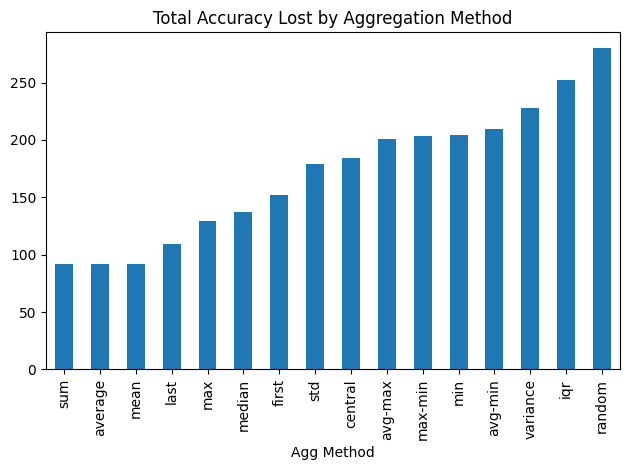

In [208]:
# Filtra o df dos resultados para só considerar os resultados com redução (PAA + agregações)
paa_results_df = results_df[results_df['aggregation'].notnull()]

# Cira um novo df para exibir o total de perda de acurácia. Usado valor absoluto para não precisar trabalhar com valores negativos
agg_summary = paa_results_df.groupby('aggregation').agg({
  'acc_diff_percent': lambda x: np.abs(x).sum(),
}).reset_index().sort_values(by='acc_diff_percent', ascending=True)

# Renomeia as colunas do DataFrame de resumo
agg_summary.columns = ['Agg Method', 'Total accuracy lost']

# Plota histograma para visualizar o total de perda de acurácia para cada método de agregação
agg_summary.plot(kind='bar', x='Agg Method', y='Total accuracy lost', legend=False)
plt.title('Total Accuracy Lost by Aggregation Method')
plt.tight_layout()
plt.show()